In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import torch
from torchvision import datasets, transforms, models 
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime

In [6]:
%load_ext jupyter_black

In [7]:
transform = transforms.Compose(
    [transforms.Resize(255), transforms.CenterCrop(224), transforms.ToTensor()]
)

In [8]:
dataset = datasets.ImageFolder("plant_leave_disease_dataset", transform=transform)

In [9]:
indices = list(range(len(dataset)))

In [10]:
split = int(np.floor(0.85 * len(dataset))) 

In [11]:
validation = int(np.floor(0.70 * split)) 

In [12]:
print(0, validation, split, len(dataset))

0 2650 3787 4456


In [13]:
print(f"length of train size :{validation}")
print(f"length of validation size :{split - validation}")
print(f"length of test size :{len(dataset)-validation}")

length of train size :2650
length of validation size :1137
length of test size :1806


In [14]:
np.random.shuffle(indices)

In [15]:
train_indices, validation_indices, test_indices = (
    indices[:validation],
    indices[validation:split],
    indices[split:],
)

In [16]:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [17]:
targets_size = len(dataset.class_to_idx)

In [76]:
# model = models.vgg16(pretrained=True)

In [77]:
# for params in model.parameters():
#     params.requires_grad = False

In [78]:
# model.classifier = nn.Sequential(
#     nn.Linear(n_features, 1024),
#     nn.ReLU(),
#     nn.Dropout(0.4),
#     nn.Linear(1024, targets_size),
# )

In [79]:
# model

In [18]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            # conv2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            # conv3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            # conv4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(50176, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, K),
        )

    def forward(self, X):
        out = self.conv_layers(X)

        # Flatten
        out = out.view(-1, 50176)

        # Fully connected
        out = self.dense_layers(out)

        return out

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [20]:
device = "cpu"

In [21]:
model = CNN(targets_size)

In [22]:
model.to(device)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [23]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
       BatchNorm2d-3         [-1, 32, 224, 224]              64
            Conv2d-4         [-1, 32, 224, 224]           9,248
              ReLU-5         [-1, 32, 224, 224]               0
       BatchNorm2d-6         [-1, 32, 224, 224]              64
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,496
              ReLU-9         [-1, 64, 112, 112]               0
      BatchNorm2d-10         [-1, 64, 112, 112]             128
           Conv2d-11         [-1, 64, 112, 112]          36,928
             ReLU-12         [-1, 64, 112, 112]               0
      BatchNorm2d-13         [-1, 64, 112, 112]             128
        MaxPool2d-14           [-1, 64,

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [25]:
def batch_gd(model, criterion, train_loader, test_laoder, epochs):
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)

    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device) #verilerin GPU veya CPU'ya taşınmasını sağlar.

            optimizer.zero_grad() #önceki gradientlerin sıfırlanmasını sağlar.

            output = model(inputs)

            loss = criterion(output, targets)

            train_loss.append(loss.item())

            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)

        validation_loss = []

        for inputs, targets in validation_loader:

            inputs, targets = inputs.to(device), targets.to(device)

            output = model(inputs)

            loss = criterion(output, targets)

            validation_loss.append(loss.item())

        validation_loss = np.mean(validation_loss)

        train_losses[e] = train_loss
        validation_losses[e] = validation_loss

        dt = datetime.now() - t0

        print(
            f"Epoch : {e+1}/{epochs} Train_loss:{train_loss:.3f} Test_loss:{validation_loss:.3f} Duration:{dt}"
        )

    return train_losses, validation_losses

In [26]:
device = "cpu"

In [27]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=test_sampler
)
validation_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=validation_sampler
)

In [28]:
train_losses, validation_losses = batch_gd(
    model, criterion, train_loader, validation_loader, 10
)

Epoch : 1/10 Train_loss:5.248 Test_loss:4.111 Duration:0:08:58.868757
Epoch : 2/10 Train_loss:3.055 Test_loss:3.708 Duration:0:07:53.953791
Epoch : 3/10 Train_loss:2.566 Test_loss:3.058 Duration:0:07:51.878168
Epoch : 4/10 Train_loss:1.975 Test_loss:2.768 Duration:0:07:23.144894
Epoch : 5/10 Train_loss:1.796 Test_loss:2.795 Duration:0:07:21.049128
Epoch : 6/10 Train_loss:1.512 Test_loss:2.647 Duration:0:07:20.348010
Epoch : 7/10 Train_loss:1.517 Test_loss:2.086 Duration:0:07:52.536604
Epoch : 8/10 Train_loss:1.318 Test_loss:3.678 Duration:0:07:58.062884
Epoch : 9/10 Train_loss:1.055 Test_loss:2.322 Duration:0:07:53.890707
Epoch : 10/10 Train_loss:1.015 Test_loss:2.646 Duration:0:07:25.749371


In [29]:
torch.save(model.state_dict(), "plant_disease_model_1.pt")

In [37]:
targets_size = 31
model = CNN(targets_size)
model.load_state_dict(torch.load("plant_disease_model_1.pt"))
model.eval()

C:\Users\MONSTER\AppData\Local\Temp\ipykernel_476\2073962476.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("plant_disease_model_1.pt")

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

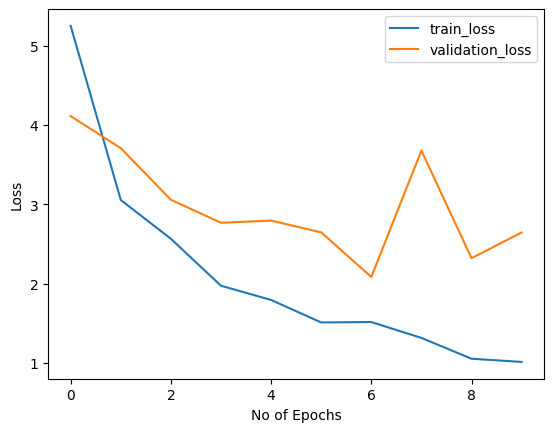

In [38]:
plt.plot(train_losses, label="train_loss")
plt.plot(validation_losses, label="validation_loss")
plt.xlabel("No of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [39]:
def accuracy(loader): #modelin doğruluk oranını hesaplamak için kullanlan fonksiyon.
    n_correct = 0
    n_total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs) #model giriş verilerini işler ve çıktı döndürür

        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item() 
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc

In [40]:
train_acc = accuracy(train_loader) #modelin öğrenmesi için kullanılan veriler 
test_acc = accuracy(test_loader) #test veri kümesindeki doğruluk oranı 
validation_acc = accuracy(validation_loader)

In [41]:
print(
    f"Train Accuracy : {train_acc}\nTest Accuracy : {test_acc}\nValidation Accuracy : {validation_acc}"
)

Train Accuracy : 0.8686792452830189
Test Accuracy : 0.7100149476831091
Validation Accuracy : 0.7220756376429199


In [42]:
transform_index_to_disease = dataset.class_to_idx #sağlıklı ve sağlıksız verileri sıfır bire döndürür

In [43]:
transform_index_to_disease = dict(
    [(value, key) for key, value in transform_index_to_disease.items()]
)  

In [44]:
data = pd.read_csv("disease_info.csv", encoding="cp1252") 

In [45]:
from PIL import Image #görüntü açmak ve kaydetmek için kullanılan kütüphane
import torchvision.transforms.functional as TF #görüntüleri tensor formatına dönüştürmek ve veri artırma için.

In [232]:
def single_prediction(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))
    input_data = TF.to_tensor(image)
    input_data = input_data.view((-1, 3, 224, 224))
    output = model(input_data)
    output = output.detach().numpy()
    index = np.argmax(output)
    pred_csv = data["disease_name"][index]
    print(pred_csv)

In [ ]:
single_prediction("plant_leave_disease_dataset/Strawberry__Leaf_scorch/image (733).JPG")

Strawberry : Leaf Scorch


In [238]:
import cv2

# Kamera başlat
cap = cv2.VideoCapture(0)

# Modeli değerlendirme moduna al
model.eval()

# Sınıf isimlerini içeren bir sözlük (isteğe bağlı, dataset.class_to_idx'den oluşturulabilir)
class_names = {v: k for k, v in dataset.class_to_idx.items()}

while True:
    ret, frame = cap.read()
    if not ret:
        print("Kameradan görüntü alınamadı.")
        break

    # OpenCV görüntüsünü Pytorch formatına dönüştür
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # BGR'den RGB'ye
    img = cv2.resize(img, (224, 224))  # Modele uygun boyuta ayarla
    img = transforms.ToTensor()(img).unsqueeze(0)  # Tensöre çevir ve batch boyutu ekle

    # Cihaz üzerinde çalıştır
    img = img.to(device)

    # Tahmin yap
    with torch.no_grad():
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)
        label = class_names[predicted.item()]  # Tahmin edilen sınıfın adı

    # Sonucu ekranda göster
    cv2.putText(
        frame,
        f"Prediction: {label}",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 255, 0),
        2,
    )
    cv2.imshow("Camera Feed", frame)

    # 'q' tuşuna basıldığında döngüyü kır
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Kamera ve pencereleri serbest bırak
cap.release()
cv2.destroyAllWindows()